<a id = 'top'></a>

[Configure Notebook](#configure)  
***

# Cross-trial aligment checks by cell  
###### For each ROI Plot average displacement normalized to roi radius as mask.

We find a trial where we know each cell is well represented by its mask. We then assume that any FOV displacement will cause the local neighborhood around the mask to shift uniformly. If the cell doesn’t move under the mask, then we should be able to reliably identify it in the local neighborhood across the experiment. To quantify displacement, we can cross correlate the small representative mask to its larger neighborhood across time.  Periods where the displacement between correlation peaks is greater than half the mask diameter can be isolated and excluded.

 
>[Calculate displacement for each ROI](#calculate)  
>[Plot](#plot)  
>[FNCC functions](#functions)  



##### Set Paths

In [2]:
qcGitDir = '/Users/Stan/Documents/myPiriform/notebooks/qc/sp041216a/'
experiment = 'sp041216a'
odorPath = '/Users/Stan/Desktop/sp041216a/odorInfo.dat'
maskPath = '/Users/Stan/Desktop/sp041216a/segmentation/maskThirdRound.dat'

sframePath = '/Users/Stan/Desktop/sp041216a/tracesDFfromTrial/sframe_processed'
rawTraces_e2_Path = '/Users/Stan/Desktop/sp041216a/e2_traces_dict.dat'
rawTraces_e3_Path = '/Users/Stan/Desktop/sp041216a/e3_traces_dict.dat'
workflowDict_e2_Path = '/Users/Stan/Desktop/sp041216a/workflow_dict_e2.dat'
workflowDict_e3_Path = '/Users/Stan/Desktop/sp041216a/workflow_dict_e3.dat'
h5FnamesDir = '/Users/Stan/Desktop/sp041216a/h5/red/'


##### Load mask and odor info

In [6]:
sframe = gl.SFrame(sframePath)
fname = '/Users/Stan/Desktop/sp041216a/h5/red/_e2_010_concatenated.h5'
mask = pickle.load(open(maskPath)).astype(int)

odorInfo = pickle.load(open(odorPath))

fnames = glob(h5FnamesDir + '*.h5')
targetfname = fnames[0]

In [7]:
targetfname

'/Users/Stan/Desktop/sp041216a/h5/red/_e2_010_concatenated.h5'

In [8]:
fnames

['/Users/Stan/Desktop/sp041216a/h5/red/_e2_010_concatenated.h5',
 '/Users/Stan/Desktop/sp041216a/h5/red/_e2_011_concatenated.h5',
 '/Users/Stan/Desktop/sp041216a/h5/red/_e2_012_concatenated.h5',
 '/Users/Stan/Desktop/sp041216a/h5/red/_e2_013_concatenated.h5',
 '/Users/Stan/Desktop/sp041216a/h5/red/_e2_014_concatenated.h5',
 '/Users/Stan/Desktop/sp041216a/h5/red/_e2_015_concatenated.h5',
 '/Users/Stan/Desktop/sp041216a/h5/red/_e2_016_concatenated.h5',
 '/Users/Stan/Desktop/sp041216a/h5/red/_e2_017_concatenated.h5',
 '/Users/Stan/Desktop/sp041216a/h5/red/_e2_018_concatenated.h5',
 '/Users/Stan/Desktop/sp041216a/h5/red/_e2_019_concatenated.h5',
 '/Users/Stan/Desktop/sp041216a/h5/red/_e2_020_concatenated.h5',
 '/Users/Stan/Desktop/sp041216a/h5/red/_e3_003_concatenated.h5',
 '/Users/Stan/Desktop/sp041216a/h5/red/_e3_004_concatenated.h5',
 '/Users/Stan/Desktop/sp041216a/h5/red/_e3_005_concatenated.h5',
 '/Users/Stan/Desktop/sp041216a/h5/red/_e3_007_concatenated.h5',
 '/Users/Stan/Desktop/sp0

<a id = 'calculate'></a>
##### Calculate cross-trial displacement
[back to top](#top)

In [9]:
mask = mask.astype(int)

In [13]:
from scipy.ndimage.measurements import center_of_mass as get_coords

odor=3
numCells = mask.max()

#get cell coords
coords = scipy.ndimage.measurements.center_of_mass(mask, mask, range(0,int(mask.max())+1))
coords[0]=(100,100)
coords[1]=(100,100)
coords = [(t[1],t[0]) for t in coords]

# #Make 2 dfs for aligned and unaligned versions. 
# #get area, radius, roi coords, 
# #get FNCC results
dfs = []
for alignmentStatus, key in {0:'current_statestep1/corrected',1:'current_statestep2/corrected'}.items():
    resultsDict  = {}   
    for cell in range(numCells)[:]:
        scores, argmax_coords, EucDist, AveEucDisplacement = runFNCC(mask, odor=3, cell=cell, 
                                                                     fnames=fnames, targetFname=targetfname,
                                                                     key = key)
        
        area = len(mask[mask==cell])
        radius = (np.power(area/np.pi,0.5))
        
        resultsDict[cell] = dict(scores = scores,
                                argmax_coords = argmax_coords,
                                EucDist = EucDist,
                                AveEucDisplacement = AveEucDisplacement,
                                Coords = coords[cell],
                                area = area,
                                radius = radius)
    
    df = pd.DataFrame(resultsDict).T
    df['aligned'] = alignmentStatus
    df['odor'] = odor
    dfs.append(df)
df = pd.concat(dfs) 

df.index.rename('cellID', inplace=True)
df.reset_index(inplace=True)
df = df.replace('exclude', np.nan)    


df['AveEucDisplacementNormed'] = df.apply(lambda x: x.AveEucDisplacement/x.radius, axis = 1)

Exception: cell 39, -7  neighborhood outside image
Exception: cell 40, -17  neighborhood outside image
Exception: cell 71, -6  neighborhood outside image
Exception: cell 171, -8  neighborhood outside image
Exception: cell 200, -4  neighborhood outside image
Exception: cell 212, -9  neighborhood outside image
Exception: cell 214, -3  neighborhood outside image
Exception: cell 215, -3  neighborhood outside image
Exception: cell 217, -1  neighborhood outside image
Exception: cell 303, 520  neighborhood outside image
Exception: cell 343, 515  neighborhood outside image
Exception: cell 380, 523  neighborhood outside image
Exception: cell 403, 514  neighborhood outside image
Exception: cell 404, 521  neighborhood outside image
Exception: cell 405, 514  neighborhood outside image
Exception: cell 407, 524  neighborhood outside image
Exception: cell 411, 518  neighborhood outside image
Exception: cell 415, 524  neighborhood outside image
Exception: cell 416, 514  neighborhood outside image
Exce

<a id = 'plot'></a>
##### Superimpose average ROI displacement on mask
[back to top](#top)

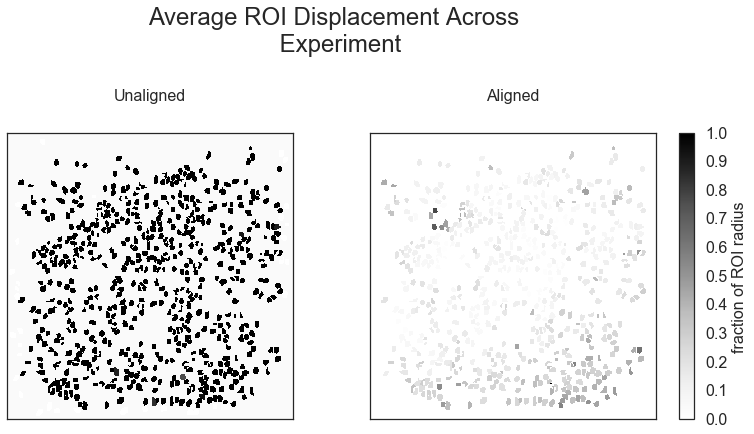

In [19]:

#get cells where there are non NANs
GoodCells = df.cellID[df.AveEucDisplacementNormed.apply(np.isfinite)].unique()

#Format Figure
f,(ax1,ax2) = plt.subplots(1,2, figsize = (12,5))
f.suptitle('Average ROI Displacement Across \n Experiment', fontsize=24, x=0.5, y=1.2)


for alignmentStatus, ax, title in [(0,ax1,'Unaligned'), (1,ax2, 'Aligned')]:
    #Make mask to plot
    masktoPlot = np.zeros_like(mask).astype(float)
    for cell in GoodCells:
        fracofRad = df[df.cellID==cell][df.aligned==alignmentStatus].AveEucDisplacementNormed.values[0]
        masktoPlot[mask==cell]=float(fracofRad)
        
    #plot and format each plot
    image = ax.imshow(masktoPlot, vmax = 1)
    image.axes.get_xaxis().set_visible(False)
    image.axes.get_yaxis().set_visible(False)
    ax.set_title(title, fontsize = 16, y = 1.1)
    if title =='Unaligned':
        cbar = plt.colorbar(image)
        cbar.set_label('fraction of ROI radius', fontsize = 16)
    plt.tight_layout()
plt.savefig(qcGitDir + 'alignmentMaskBeforeAfter.png',bbox_inches='tight', pad_inches=0.5 )

<a id = 'functions'></a>
##### Define FNCC Functions
[back to top](#top)

In [11]:
e2Trials = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
e3Trials = [3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

In [12]:

def runFNCC(mask, odor, cell, fnames, targetFname, key = 'current_statestep2/corrected',
            awakeTrials = e2Trials,anesthetizedTrials = e3Trials,
            awakeEpoch = 2,anesthetizedEpoch = 3 ):
    from skimage.feature import match_template
    """
    We load the preprocessed red channel neighborhood for a cell-odor pair for all trials. We then calculate 
    the displacement of the peak from a reference trial across all other trials. 
    """
    
    odor = odor
    cell = cell

    coords = scipy.ndimage.measurements.center_of_mass(mask, mask, range(0,int(mask.max())+1))
    coords[0]=(100,100)
    coords[1]=(100,100)
    coords = [(int(t[1]),int(t[0])) for t in coords]

    #Specify dimensions  of local neighborhood
    halfRad = 25
    yi = coords[cell][1]-halfRad
    yf = coords[cell][1]+halfRad
    xi = coords[cell][0]-halfRad
    xf = coords[cell][0]+halfRad
    
    #Edge Exception. Return's None for cells on the edge. 
    for _ in [yi, yf, xi,xf]:
        if _<0 or _>512:
            print 'Exception: ' 'cell {},'.format(cell), _, " neighborhood outside image"
            return 'exclude', 'exclude', 'exclude', 'exclude' 
    #Specify dimensions of target 
    xstart = 10
    ystart = 10
    targetW = 30
    targetH = 30
    
    #load target 
    epoch,trialID = [int(_) for _ in re.split('_e|_con|_',targetfname)[-3:-1]]
    
    odorFrames_i, odorFrames_f = odorInfo['epoch{}'.format(epoch)][trialID-1]['pre_odor_post_interval'][odor]
    with h5py.File(targetFname, 'r+') as f:    
        target = f[key][yi:yf,xi:xf, odorFrames_i:odorFrames_f]  
        
    #Make actual target
    actualTarget = target[xstart:xstart+targetW, ystart:ystart+targetH]
    actualTarget = actualTarget.mean(2)


    #Make Mask Overlay
    overlay = np.ma.MaskedArray(mask.astype(bool), np.invert(mask.astype(bool)).astype(bool))

    #Run target search on all trials
    scores = []
    argmax_coords = []
    EucDist = []    
    for fname in fnames:
        epoch,trialID = [int(_) for _ in re.split('_e|_con|_',fname)[-3:-1]]
        if (epoch == awakeEpoch) & (trialID not in awakeTrials) | (epoch == anesthetizedEpoch) & (trialID not in anesthetizedTrials):
            continue
        
        #get odor Info
        odorFrames_i, odorFrames_f = [odorInfo['epoch{}'.format(epoch)][_] for _ in range(len(odorInfo['epoch{}'.format(epoch)]))
        if odorInfo['epoch{}'.format(epoch)][_]['trialID']==trialID][0]['pre_odor_post_interval'][odor]
        #Load trial neighborhood
        with h5py.File(fname, 'r+') as f:    
            trial = f[key][yi:yf,xi:xf, odorFrames_i:odorFrames_f].mean(2)

        #Execute Fast normalized cross-correlation
        result = match_template(trial, actualTarget)


        #Obtain correlation values
        i,j = np.unravel_index(np.argmax(result),result.shape)
        scores.append(result[i,j])
        argmax_coords.append((i,j))

        #Obtain average Euclidian distance
        from scipy.spatial import distance
        EucDist.append(distance.pdist(np.array([(10,10),(i,j)]),'euclidean'))
    AveEucDisplacement = np.vstack(EucDist).mean()
    return scores, argmax_coords, EucDist, AveEucDisplacement


def runFNCConCorr(mask, odor, cell, fnames, targetFname, key = 'current_statestep2/corrected' ):
    from skimage.feature import match_template
    from sklearn.preprocessing import scale
    """
    We load the preprocessed red channel neighborhood for a cell-odor pair for all trials. We then calculate 
    the displacement of the peak from a reference trial across all other trials. 
    """
    
    odor = odor
    cell = cell

    coords = scipy.ndimage.measurements.center_of_mass(mask, mask, range(0,int(mask.max())+1))
    coords[0]=(0.0,0.0)
    coords = [(int(t[1]),int(t[0])) for t in coords]

    #Specify dimensions  of local neighborhood
    halfRad = 25
    yi = coords[cell][1]-halfRad
    yf = coords[cell][1]+halfRad
    xi = coords[cell][0]-halfRad
    xf = coords[cell][0]+halfRad
    
    #Edge Exception. Return's None for cells on the edge. 
    for _ in [yi, yf, xi,xf]:
        if _<0 or _>512:
            print 'Exception: ' 'cell {},'.format(cell), _, " neighborhood outside image"
            return 'exclude', 'exclude', 'exclude', 'exclude' 
    #Specify dimensions of target 
    xstart = 10
    ystart = 10
    targetW = 30
    targetH = 30
    
    #load target 
    epoch,trialID = [int(_) for _ in re.split('_e|_con|_',targetfname)[-3:-1]]
    odorFrames_i, odorFrames_f = odorInfo['epoch{}'.format(epoch)][trialID-1]['pre_odor_post_interval'][odor]
    with h5py.File(targetFname, 'r+') as f:    
        target = f[key][yi:yf,xi:xf, odorFrames_i:odorFrames_f] 
    #Correlate
    h,w,numFrames = target.shape
    corrWin = 2
    #scale each frame
    scaled = np.empty((h,w,numFrames))
    for i, frame in enumerate([scale(target[...,frame]) for frame in range(numFrames)]):
        scaled[...,i] = frame
    #Correlate    
    targetCorr = np.empty((h,w))
    for i in range(0,h):
        for j in range(0,w):
            targetCorr[i,j] = np.correlate(scaled[i,j,:],scaled[i-corrWin:i+corrWin, j-corrWin:j+corrWin,:].mean(0).mean(0))

        
    #Make actual target
    actualTarget = targetCorr[xstart:xstart+targetW, ystart:ystart+targetH]
    #actualTarget = actualTarget.mean(2)
    

    #Make Mask Overlay
    overlay = np.ma.MaskedArray(mask.astype(bool), np.invert(mask.astype(bool)).astype(bool))

    #Run target search on all trials
    scores = []
    argmax_coords = []
    EucDist = []    
    for ifname, fname in enumerate(fnames):
        epoch,trialID = [int(_) for _ in re.split('_e|_con|_',fname)[-3:-1]]
        #get odor Info
        odorFrames_i, odorFrames_f = odorInfo['epoch{}'.format(epoch)][trialID-1]['pre_odor_post_interval'][odor]

        #Load trial neighborhood
        with h5py.File(fname, 'r+') as f:    
            trial = f[key][yi:yf,xi:xf, odorFrames_i:odorFrames_f]
        #Correlate
        h,w,numFrames = trial.shape
        corrWin = 2
        #scale each frame
        scaled = np.empty((h,w,numFrames))
        for i, frame in enumerate([scale(trial[...,frame]) for frame in range(numFrames)]):
            scaled[...,i] = frame
        #Correlate    
        trial = np.empty((h,w))
        for i in range(0,h):
            for j in range(0,w):
                trial[i,j] = np.correlate(scaled[i,j,:],scaled[i-corrWin:i+corrWin, j-corrWin:j+corrWin,:].mean(0).mean(0))
        #fix NAN values
        trial=np.nan_to_num(trial)
        trial[trial==0] = trial[corrWin:,corrWin].flatten().mean()
        #Execute Fast normalized cross-correlation
        result = match_template(trial, actualTarget)
#         if ifname ==1:
#             return trial, actualTarget

        #Obtain correlation values
        i,j = np.unravel_index(np.argmax(result),result.shape)
        scores.append(result[i,j])
        argmax_coords.append((i,j))
        
        #Obtain average Euclidian distance
        from scipy.spatial import distance
        EucDist.append(distance.pdist(np.array([(10,10),(i,j)]),'euclidean'))
    AveEucDisplacement = np.vstack(EucDist).mean()
    return scores, argmax_coords, EucDist, AveEucDisplacement

<a id = 'configure'></a>
##### Configure Notebook
[back to top](#top)

In [1]:

import sys
sys.path.append('/users/stan/documents/')
import os
from glob import glob
import copy
import numpy as np

from d_code.imaging.io import tifffile
import matplotlib.pylab as plt
from joblib import Parallel, delayed
from collections import defaultdict
from scipy import signal
from time import time
import cPickle as pickle
import spUtils
import seaborn as sns
import h5py
import re
import graphlab as gl
gl.canvas.set_target('ipynb')
import pandas as pd

sns.set_palette("husl")
sns.set_style("white")
sns.set_context("poster")


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#style notebook
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())

2016-05-08 17:20:07,710 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.9 started. Logging: /tmp/graphlab_server_1462742406.log


This non-commercial license of GraphLab Create is assigned to stanlp86@gmail.com and will expire on October 28, 2016. For commercial licensing options, visit https://dato.com/buy/.
